In this notebook, we will do time series forecasting on the Etth2 dataset. The dataset contains data from two electricity transformers collected for two years at an hourly rate. The goal is to predict oil temperature. Here, we are predicting the next 36 h = 1.5 d (=prediction_length) given a history of 72 h = 3 d (=context_length).

Just as in the previous notebook in this repository, we will start off by using a Seq2Seq LSTM model for prediction (but this time in PyTorch). In this approach, data will be min-max scaled. A recent paper by Kim et al:
* Kim et al.: [Reversible instance normalization for accurate time-series forecasting against distribution shift](https://openreview.net/pdf?id=cGDAkQo1C0p). 2022

shows that this type of scaling is inferior to reversible instance normalization (RevIN). Therefore, we will compare how incorporating the RevIN scaling approach affects our Seq2Seq LSTM model.

In a next step, we will compare how our Seq2Seq LSTM model compares to the SCINet model as introduced by Liu et al.:
* Liu et al.: [SCINet: Time Series Modeling and Forecasting with
Sample Convolution and Interaction](https://arxiv.org/pdf/2106.09305.pdf). 2022

SCINet has achieved state-of-the-art results on multiple datasets recently, espcially for predicting long time series. We will  investigate how it performs both with and without RevIN scaling compared to our Seq2Seq LSTM model.

So, without further ado: Let's start by getting the Etth2 dataset.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
import torch.nn.functional as F
import pytorch_lightning as pl
from torchinfo import summary
from extra.schedulers import MultiplicativeDecayWithReduceOrRestartOnPlateau
import random
import logging
from pathlib import Path
from sklearn.metrics import mean_absolute_error
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
pd.set_option("display.precision", 2)
random.seed(4)
torch.manual_seed(4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv"
df = pd.read_csv(url)
df.head()

cpu


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.13,12.48,36.54,9.35,4.42,1.31,38.66
1,2016-07-01 01:00:00,37.53,10.14,33.94,7.53,4.43,1.22,37.12
2,2016-07-01 02:00:00,37.95,11.31,35.33,9.01,2.10,0.00,36.47
3,2016-07-01 03:00:00,38.95,11.90,35.54,9.44,3.38,1.22,33.61
4,2016-07-01 04:00:00,38.11,11.48,35.41,9.62,2.04,0.00,31.85


Just as previously, we will use cyclical encoding to encode "day of the year" and also "hour of the day" information:

In [2]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S")
df["sin_d"] = df["date"].map(
    lambda x: np.sin((2 * np.pi * (x.timetuple().tm_hour)) / 24))       
df["cos_d"] = df["date"].map(
    lambda x: np.cos((2 * np.pi * (x.timetuple().tm_hour)) / 24))
df["sin_y"] = df["date"].map(
    lambda x: np.sin(
        (2 * np.pi * (x.timetuple().tm_yday + 
                      x.timetuple().tm_hour / 24)) / 365.25))
df["cos_y"] = df["date"].map(
    lambda x: np.cos((2 * np.pi * (x.timetuple().tm_yday + 
                                   x.timetuple().tm_hour / 24)) / 365.25))
df = df.drop(columns="date")

As stated, the goal in this notebook is to predict oil temperature for the following 36 h given a history of 72 h:

In [3]:
# General time series-related parameters
pred_len = 36
context_len = 72
n_feat_in = 11
n_feat_out = 1
delay = 0
roll_ts = 3
x_cols_to_scale = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
x_cols = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT", "sin_d", 
          "cos_d", "sin_y", "cos_y"]
y_cols = ["OT"]

# General training parameters
batch_size = 64

Let's split the data into train, validation and test data:

In [4]:
def split_df(df, train_ratio, val_ratio):
    train_max_idx = int(len(df) * train_ratio)
    val_max_idx = train_max_idx + int(len(df) * val_ratio)
        
    df_train = df[0:train_max_idx].reset_index(drop=True)
    df_val = df[train_max_idx:val_max_idx].reset_index(drop=True)
    df_test = df[val_max_idx:].reset_index(drop=True)
    return df_train, df_val, df_test

df_train, df_val, df_test = split_df(df, train_ratio=0.6, val_ratio=0.2)

And min-max scale the data for the approaches that do not use the RevIN module:

In [5]:
class MinMaxScaler:
    def fit(self, df, cols):
        self.cols = cols
        self.cols_idx = [
            np.where(df_train.columns == col)[0].tolist()[0] for col in cols]

        self.mins = [df.loc[:, col].min() for col in self.cols]
        self.maxs = [df.loc[:, col].max() for col in self.cols]

    def transform(self, df):
        df_copy = df.copy()
        
        for idx, col in enumerate(self.cols):
            df_copy.loc[:, col] = ((df_copy.loc[:, col] - self.mins[idx]) /
                                   (self.maxs[idx] - self.mins[idx]))
        return df_copy    
        
    def inverse_transform(self, y_scaled):
        """
        Accepts a scaled torch tensor of shape (pred_len, n_feat_out)
        """
        y_scaled = copy.deepcopy(y_scaled.numpy())
        
        for i in range(len(self.cols_idx)):
            y_scaled[:, :, i] = y_scaled[:, :, i] * \
                (self.maxs[i] - self.mins[i]) + self.mins[i]
        return y_scaled


scaler_X = MinMaxScaler()
scaler_X.fit(df_train, x_cols_to_scale)
df_train_scaled = scaler_X.transform(df_train)

scaler_y = MinMaxScaler()
scaler_y.fit(df_train_scaled, y_cols)
df_train_scaled = scaler_y.transform(df_train_scaled)

df_val_scaled = scaler_X.transform(df_val)
df_val_scaled = scaler_y.transform(df_val_scaled)

df_test_scaled = scaler_X.transform(df_test)
df_test_scaled = scaler_y.transform(df_test_scaled)

...And create a Pytorch dataset:

In [6]:
class CustomDataset(Dataset):
    def __init__(self, df, pred_len, context_len, delay, roll_ts, 
                 x_cols, y_cols):
        self.df = df
        self.pred_len = pred_len
        self.context_len = context_len
        self.delay = delay
        self.x_cols = x_cols
        self.y_cols = y_cols
        
        if roll_ts != 0:
            self.window_len = roll_ts
        else:
            self.window_len = context_len + pred_len + delay
        
        self.create_idx()
        
    def create_idx(self):
        idx_x_start = list(range(0, len(self.df), self.window_len))
        idx_x_end = list(range(self.context_len, len(self.df), 
                               self.window_len))
        self.idx_x = [list(range(x[0], x[1])) for x in 
                 list(zip(idx_x_start, idx_x_end))]
        
        idx_y_start = [x+self.delay for x in idx_x_end]
        idx_y_end = [x+self.pred_len for x in idx_y_start]
        
        idx_to_remove = [idx for (idx, x) in enumerate(idx_y_end) 
                         if x > len(self.df)]
        
        if len(idx_to_remove) > 0:
            self.idx_x = self.idx_x[:idx_to_remove[0]]
            idx_y_start = idx_y_start[:idx_to_remove[0]]
            idx_y_end = idx_y_end[:idx_to_remove[0]]
            
        self.idx_y = [list(range(x[0], x[1])) for x in 
                 list(zip(idx_y_start, idx_y_end))]

    def __len__(self):
        return len(self.idx_x)

    def __getitem__(self, idx):
        x = torch.tensor(
            self.df.loc[self.idx_x[idx], self.x_cols].values).float()
        y = torch.tensor(
            self.df.loc[self.idx_y[idx], self.y_cols].values).float()
        return x, y
        

ds_train_scaled = CustomDataset(
    df_train_scaled, pred_len=pred_len, context_len=context_len,
    delay=delay, roll_ts=roll_ts, x_cols=x_cols, y_cols=y_cols)
ds_val_scaled = CustomDataset(
    df_val_scaled, pred_len=pred_len, context_len=context_len,
    delay=delay, roll_ts=roll_ts, x_cols=x_cols, y_cols=y_cols)
ds_test_scaled = CustomDataset(
    df_test_scaled, pred_len=pred_len, context_len=context_len,
    delay=delay, roll_ts=roll_ts, x_cols=x_cols, y_cols=y_cols)

loader_train_scaled = DataLoader(
    ds_train_scaled, batch_size=batch_size, shuffle=True)
loader_val_scaled = DataLoader(
    ds_val_scaled, batch_size=batch_size, shuffle=False)
loader_test_scaled = DataLoader(
    ds_test_scaled, batch_size=batch_size, shuffle=False)

# Seq2Seq LSTM model without RevIN

First, we will try out a basic Seq2Seq LSTM model with the min-max scaled data. Let's define this model:

In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, pred_len, n_feat_in, n_feat_out, n_hidden, n_layers):
        super(Seq2Seq, self).__init__()  
        self.lstm1 = nn.LSTM(input_size=n_feat_in, hidden_size=n_hidden,
                             num_layers=n_layers, batch_first=True)
        self.pred_len = pred_len
        self.n_hidden = n_hidden
        self.lstm2 = nn.LSTM(input_size=n_hidden, hidden_size=n_hidden,
                             num_layers=n_layers, batch_first=True)
        self.linear1 = nn.Linear(n_hidden, n_hidden*2)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(n_hidden*2, n_feat_out)
        
    def forward(self, x):
        x, (hidden, _) = self.lstm1(x)
        x = hidden[-1, :, :].repeat(1, 1, self.pred_len)
        x = x.reshape(-1, self.pred_len, self.n_hidden)
        x, (hidden, _) = self.lstm2(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x      

...and some training hyperparameters

In [8]:
# Seq2Seq model parameter
n_layers = 2
n_hidden = 128

# General training parameters
epochs = 150
patience_early_stopping = 50

lr_after_warmup = 8e-5
lr_decay = 0.98
lr_max = lr_after_warmup * 5
lr_min = 5e-8
warmup_epochs = 10
f_reduction = 0.25
f_restart = 1.25
patience = 4
min_loss_improvement = 0.005
no_of_restarts_init = 2
increment_no_of_restarts = 2

...and train:

In [9]:
cb_a1 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b1 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c1 = LearningRateMonitor(logging_interval="epoch")
logger1 = CSVLogger(
    save_dir="logs_002/", name="model001", flush_logs_every_n_steps=1)


class TrainingModuleBase(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.automatic_optimization = False

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        opt.zero_grad()
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)
        loss = F.mse_loss(y_pred, y)
        
        # For logging loss & metrics
        self.log("train_loss", loss, on_step=False, on_epoch=True, 
                 prog_bar=False)
        
        self.manual_backward(loss)
        opt.step()
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)
        loss = F.mse_loss(y_pred, y)
        
        # For logging loss & metrics
        self.log("val_loss", loss, on_step=False, on_epoch=True, 
                  prog_bar=False)
        
        # Take care of non-default scheduler
        if batch_idx == 0:
            self.cur_val_loss = []   
        self.cur_val_loss.append(loss)
        return loss
    
    def on_validation_epoch_end(self):
        # Take care of non-default scheduler
        self.cur_val_loss = torch.stack(self.cur_val_loss).mean()
        self.scheduler.step(self.cur_val_loss)
       
    def predict_step(self, batch, batch_idx):
        if isinstance(batch, list): # Dataloaders that return both X and y
            return self(batch[0]), batch[1]
        else: # Dataloaders that return only y
            return self(batch[0])
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=lr_min)
        self.scheduler = MultiplicativeDecayWithReduceOrRestartOnPlateau(
            optimizer=opt, lr_after_warmup=lr_after_warmup, lr_decay=lr_decay, 
            lr_max=lr_max, lr_min=lr_min, warmup_epochs=warmup_epochs,
            f_reduction=f_reduction, f_restart=f_restart, patience=patience, 
            min_loss_improvement=min_loss_improvement, 
            no_of_restarts_init=no_of_restarts_init, 
            increment_no_of_restarts=increment_no_of_restarts)
        return opt


class TrainingModule1(TrainingModuleBase):
    def __init__(self, pred_len, n_feat_in, n_feat_out, n_hidden, n_layers):
        super().__init__()
        self.automatic_optimization = False
        self.seq2seq = Seq2Seq(
            pred_len=pred_len, n_feat_in=n_feat_in, n_feat_out=n_feat_out, 
            n_hidden=n_hidden, n_layers=n_layers)
        
    def forward(self, x):
        x = self.seq2seq(x)
        return x


model001 = TrainingModule1(
    pred_len=pred_len, n_feat_in=n_feat_in, n_feat_out=n_feat_out, 
    n_hidden=n_hidden, n_layers=n_layers)

print(summary(model001.to(device), (1, context_len, n_feat_in), depth=5))
trainer1 = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, enable_progress_bar=False,
    callbacks=[cb_a1, cb_b1, cb_c1], logger=logger1, accelerator="cpu")

trainer1.fit(
    model=model001, train_dataloaders=loader_train_scaled, 
    val_dataloaders=loader_val_scaled)

Layer (type:depth-idx)                   Output Shape              Param #
TrainingModule1                          [1, 36, 1]                --
├─Seq2Seq: 1-1                           [1, 36, 1]                --
│    └─LSTM: 2-1                         [1, 72, 128]              204,288
│    └─LSTM: 2-2                         [1, 36, 128]              264,192
│    └─Linear: 2-3                       [1, 36, 256]              33,024
│    └─ReLU: 2-4                         [1, 36, 256]              --
│    └─Linear: 2-5                       [1, 36, 1]                257
Total params: 501,761
Trainable params: 501,761
Non-trainable params: 0
Total mult-adds (M): 24.25
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 2.01
Estimated Total Size (MB): 2.19


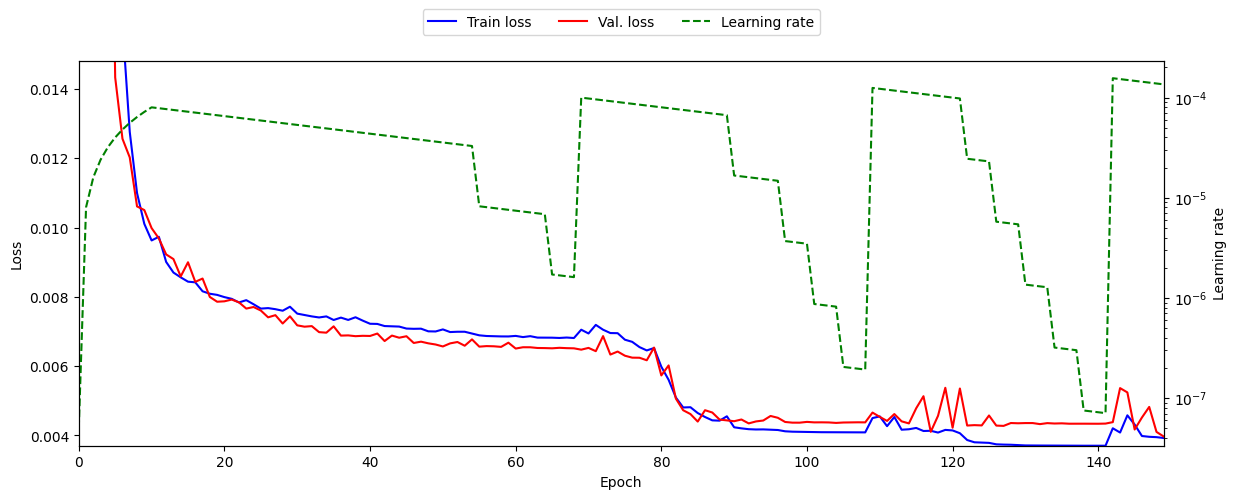

In [10]:
def plot_training_progress(log_dir_path):
    logs = pd.read_csv(Path(log_dir_path))
    epochs = logs.dropna(subset=["train_loss"])["epoch"]
    
    fig1, ax1 = plt.subplots(1, 1, figsize=(14, 5))
    l1 = ax1.plot(
        epochs, logs["train_loss"].dropna(), color="b", label="Train loss")
    l2 = ax1.plot(
        epochs, logs["val_loss"].dropna(), color="r", label="Val. loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_xlim(0, len(epochs)-1)
    loss_min = min(logs["val_loss"].min(), logs["train_loss"].min()) 
    ax1.set_ylim(loss_min, loss_min*4)
    ax2 = ax1.twinx() 
    l3 = ax2.plot(
        epochs, logs["lr-Adam"].dropna(), color="g", linestyle="dashed", 
        label="Learning rate")
    ax2.set_ylabel("Learning rate")
    ax2.set_yscale("log")
    ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc="lower center", 
                bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
    plt.show()

plot_training_progress(trainer1.logger.log_dir + "/metrics.csv")

Let's check the overall mean absolute error on the test data:

In [11]:
checkpoint_file = trainer1.checkpoint_callback.best_model_path
model001 = model001.load_from_checkpoint(
    checkpoint_file, pred_len=pred_len, n_feat_in=n_feat_in, 
    n_feat_out=n_feat_out, n_hidden=n_hidden, n_layers=n_layers)
model001.eval()

trainer1a = pl.Trainer()
y_test_out1 = trainer1a.predict(model=model001, dataloaders=loader_test_scaled)
y_test_pred1 = torch.cat([x[0] for x in y_test_out1])
y_test1 = torch.cat([x[1] for x in y_test_out1])

y_test_rescaled1 = scaler_y.inverse_transform(y_test1)
y_test_pred_rescaled1 = scaler_y.inverse_transform(y_test_pred1)
mae1 = mean_absolute_error(
    y_test_rescaled1[:, :, 0], y_test_pred_rescaled1[:, :, 0])
print(f"The mean absolute error on the test set is: {mae1:.2f}")

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.92it/s]
The mean absolute error on the test set is: 3.99


...and visualize an exemplary predicted time series:

The mean absolute error on the shown time series is: 2.14


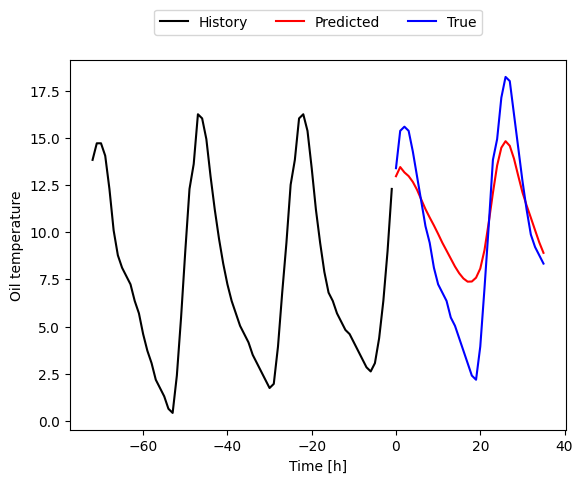

In [12]:
y_test_history = torch.cat(
    [x[0][None, :, 6] for x in ds_test_scaled])[:, :, None]
y_test_history = scaler_y.inverse_transform(y_test_history)


def plot_example_time_series(y, y_pred, y_history, idx, context_len):
    mae = mean_absolute_error(y[idx, :, 0], y_pred[idx, :, 0])
    print(f"The mean absolute error on the shown time series is: {mae:.2f}")
    
    fig, ax = plt.subplots()
    ax.plot(list(range(-context_len, 0)), 
        y_history[idx, :, 0], color="k", label="History")
    ax.plot(list(range(0, pred_len)), 
        y_pred[idx, :, 0], color="r", label="Predicted")
    ax.plot(list(range(0, pred_len)), 
        y[idx, :, 0], color="b", label="True")
    ax.set_ylabel("Oil temperature")
    ax.set_xlabel("Time [h]")
    ax.legend(loc="lower center", bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
    plt.show()


plot_example_time_series(
    y_test_rescaled1, y_test_pred_rescaled1, y_test_history, 23, context_len)

# Seq2Seq LSTM model with RevIN

Next, we will train the same Seq2Seq LSTM model without prescaling but "internal scaling" using the RevIN module. The code for the RevIN module is (with slight adoptions) taken from this Github repository:
* https://github.com/ts-kim/RevIN

Therefore, the respective license (here [MIT license](https://github.com/ts-kim/RevIN/blob/master/License)) applies to the code

In [13]:
ds_train = CustomDataset(
    df_train, pred_len=pred_len, context_len=context_len,
    delay=delay, roll_ts=roll_ts, x_cols=x_cols, y_cols=y_cols)
ds_val = CustomDataset(
    df_val, pred_len=pred_len, context_len=context_len,
    delay=delay, roll_ts=roll_ts, x_cols=x_cols, y_cols=y_cols)
ds_test = CustomDataset(
    df_test, pred_len=pred_len, context_len=context_len,
    delay=delay, roll_ts=roll_ts, x_cols=x_cols, y_cols=y_cols)

loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)


class RevIN(nn.Module):
    def __init__(self, num_features, y_cols_idx, eps=1e-5, affine=True):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.y_cols_idx = y_cols_idx
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == "norm":
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == "denorm":
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, 
                                          unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias[self.y_cols_idx]
            x = x / (self.affine_weight[self.y_cols_idx] + self.eps*self.eps)
        x = x * self.stdev[:, :, self.y_cols_idx]
        x = x + self.mean[:, :, self.y_cols_idx]
        return x

    
cb_a2 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b2 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c2 = LearningRateMonitor(logging_interval="epoch")
logger2 = CSVLogger(
    save_dir="logs_002/", name="model002", flush_logs_every_n_steps=1)


class TrainingModule2(TrainingModuleBase):
    def __init__(self, pred_len, n_feat_in, n_feat_out, n_hidden, n_layers, 
                 y_cols_idx):
        super().__init__()
        self.automatic_optimization = False
        self.seq2seq = Seq2Seq(
            pred_len=pred_len, n_feat_in=n_feat_in, n_feat_out=n_feat_out, 
            n_hidden=n_hidden, n_layers=n_layers)
        self.revin = RevIN(n_feat_in, y_cols_idx)
        
    def forward(self, x):
        x = self.revin(x, "norm")
        x = self.seq2seq(x)
        x = self.revin(x, "denorm")
        return x

y_cols_idx = [df.columns.get_loc(x) for x in y_cols]

model002 = TrainingModule2(
    pred_len=pred_len, n_feat_in=n_feat_in, n_feat_out=n_feat_out, 
    n_hidden=n_hidden, n_layers=n_layers, y_cols_idx=y_cols_idx)

print(summary(model002.to(device), (1, context_len, n_feat_in), depth=5))

trainer2 = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, enable_progress_bar=False,
    callbacks=[cb_a2, cb_b2, cb_c2], logger=logger2, accelerator="cpu")

trainer2.fit(
    model=model002, train_dataloaders=loader_train, val_dataloaders=loader_val)

Layer (type:depth-idx)                   Output Shape              Param #
TrainingModule2                          [1, 36, 1]                --
├─RevIN: 1-1                             [1, 72, 11]               22
├─Seq2Seq: 1-2                           [1, 36, 1]                --
│    └─LSTM: 2-1                         [1, 72, 128]              204,288
│    └─LSTM: 2-2                         [1, 36, 128]              264,192
│    └─Linear: 2-3                       [1, 36, 256]              33,024
│    └─ReLU: 2-4                         [1, 36, 256]              --
│    └─Linear: 2-5                       [1, 36, 1]                257
├─RevIN: 1-3                             [1, 36, 1]                (recursive)
Total params: 501,783
Trainable params: 501,783
Non-trainable params: 0
Total mult-adds (M): 24.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 2.01
Estimated Total Size (MB): 2.20


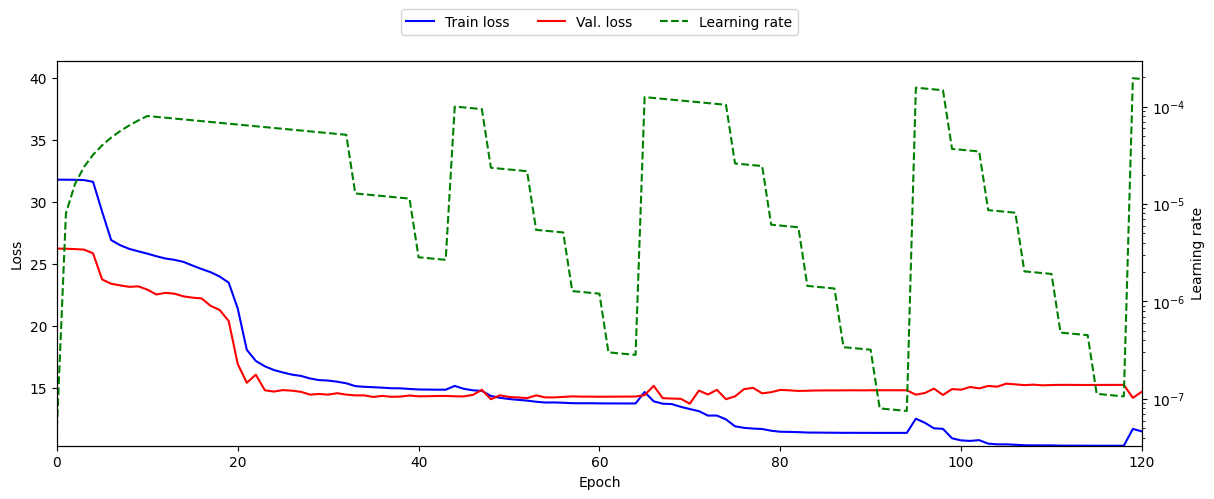

In [14]:
plot_training_progress(trainer2.logger.log_dir + "/metrics.csv")

Overall, using the RevIN module does slightly improve results:

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.69it/s]
The mean absolute error on the test set is: 3.79
The mean absolute error on the shown time series is: 2.03


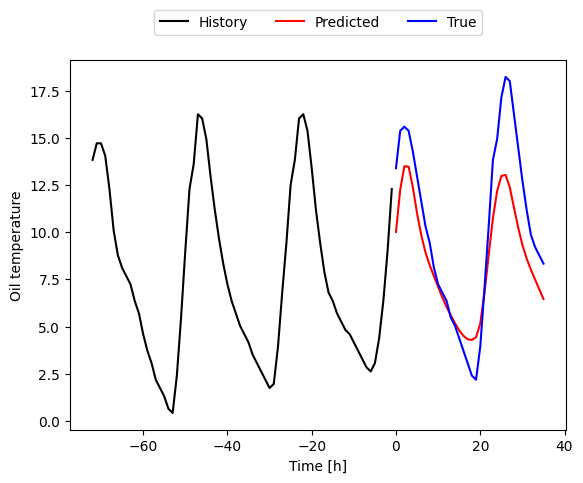

In [15]:
checkpoint_file = trainer2.checkpoint_callback.best_model_path
model002 = model002.load_from_checkpoint(
    checkpoint_file, pred_len=pred_len, n_feat_in=n_feat_in, 
    n_feat_out=n_feat_out, n_hidden=n_hidden, n_layers=n_layers, 
    y_cols_idx=y_cols_idx)
model002.eval()

trainer2a = pl.Trainer()
y_test_out2 = trainer2a.predict(model=model002, dataloaders=loader_test)
y_test_pred2 = torch.cat([x[0] for x in y_test_out2])
y_test2 = torch.cat([x[1] for x in y_test_out2])

mae2 = mean_absolute_error(
    y_test2[:, :, 0], y_test_pred2[:, :, 0])
print(f"The mean absolute error on the test set is: {mae2:.2f}")

plot_example_time_series(
    y_test2, y_test_pred2, y_test_history, 23, context_len)

# SCINet without RevIN

Now, we will train the SCINet model on the same dataset. The code is (with some adaptions) taken from the following Github repostiory:
* https://github.com/cure-lab/SCINet

Therefore, the respective license (here [Apache License 2.0](https://github.com/cure-lab/SCINet/blob/main/LICENSE)) applies to the code.

The modifications mostly relate to removing some "advanced features" like stacking and positional encoding from the model to make the core of the model more easily understandable. Also, the projection layers after the SCINet block are modified. Furthermore, some code cleaning was performed to ease understanding. E.g., some repetitive code sequences like the intialization of the phi, psi, U, and P module are shortened. Additional the original code initializes for example Conv2d and Batchnorm2d layers even though they are not part of the model... 

In [16]:
class Splitting(nn.Module):
    def __init__(self):
        super(Splitting, self).__init__()

    def even(self, x):
        return x[:, ::2, :]

    def odd(self, x):
        return x[:, 1::2, :]

    def forward(self, x):
        return (self.even(x), self.odd(x))


class Interactor(nn.Module):
    def __init__(self, in_channels, kernel_size, dropout, hidden_size):
        super(Interactor, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.hidden_size = hidden_size
        if self.kernel_size % 2 == 0:
            self.pad_l = (self.kernel_size - 2) // 2 + 1 
            self.pad_r = (self.kernel_size) // 2 + 1
        else:
            self.pad_l = (self.kernel_size - 1) // 2 + 1
            self.pad_r = (self.kernel_size - 1) // 2 + 1
        self.split = Splitting()

        self.phi = nn.Sequential(*self._create_submodule())
        self.psi = nn.Sequential(*self._create_submodule())
        self.U = nn.Sequential(*self._create_submodule())
        self.P = nn.Sequential(*self._create_submodule())
        
    def _create_submodule(self):
        return [
            nn.ReplicationPad1d((self.pad_l, self.pad_r)),
            nn.Conv1d(
                self.in_channels, int(self.in_channels * self.hidden_size),
                kernel_size=self.kernel_size),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(
                int(self.in_channels * self.hidden_size), self.in_channels,
                kernel_size=3),
            nn.Tanh()
            ]

    def forward(self, x):
        (x_even, x_odd) = self.split(x)

        x_even = x_even.permute(0, 2, 1)
        x_odd = x_odd.permute(0, 2, 1)

        d = x_odd.mul(torch.exp(self.phi(x_even)))
        c = x_even.mul(torch.exp(self.psi(x_odd)))

        x_even_update = c + self.U(d)
        x_odd_update = d - self.P(c)
        return (x_even_update, x_odd_update)


class InteractorLevel(nn.Module):
    def __init__(self, in_channels, kernel_size, dropout, hidden_size):
        super(InteractorLevel, self).__init__()
        self.level = Interactor(
            in_channels=in_channels, kernel_size=kernel_size, dropout=dropout, 
            hidden_size=hidden_size)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.level(x)
        return (x_even_update, x_odd_update)


class LevelSCINet(nn.Module):
    def __init__(self, in_channels, kernel_size, dropout, hidden_size):
        super(LevelSCINet, self).__init__()
        self.interact = InteractorLevel(
            in_channels=in_channels, kernel_size=kernel_size, dropout=dropout, 
            hidden_size=hidden_size)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.interact(x)
        return x_even_update.permute(0, 2, 1), x_odd_update.permute(0, 2, 1)


class SCINet_Tree(nn.Module):
    def __init__(self, in_channels, current_level, kernel_size, dropout, 
                 hidden_size):
        super().__init__()
        self.current_level = current_level
        self.workingblock = LevelSCINet(
            in_channels=in_channels, kernel_size=kernel_size, dropout=dropout,
            hidden_size=hidden_size)

        if current_level != 0:
            self.SCINet_Tree_odd = SCINet_Tree(
                in_channels, current_level-1, kernel_size, dropout, 
                hidden_size)
            self.SCINet_Tree_even = SCINet_Tree(
                in_channels, current_level-1, kernel_size, dropout, 
                hidden_size)
    
    def zip_up_the_pants(self, even, odd):
        even = even.permute(1, 0, 2)
        odd = odd.permute(1, 0, 2) #L, B, D
        even_len = even.shape[0]
        odd_len = odd.shape[0]
        mlen = min((odd_len, even_len))
        _ = []
        
        for i in range(mlen):
            _.append(even[i].unsqueeze(0))
            _.append(odd[i].unsqueeze(0))
        if odd_len < even_len: 
            _.append(even[-1].unsqueeze(0))
        return torch.cat(_, 0).permute(1, 0, 2) #B, L, D
        
    def forward(self, x):
        x_even_update, x_odd_update= self.workingblock(x)

        if self.current_level == 0:
            return self.zip_up_the_pants(x_even_update, x_odd_update)
        else:
            return self.zip_up_the_pants(self.SCINet_Tree_even(x_even_update), 
                                         self.SCINet_Tree_odd(x_odd_update))


class EncoderTree(nn.Module):
    def __init__(self, in_channels, num_levels, kernel_size, dropout, 
                 hidden_size):
        super().__init__()
        self.levels=num_levels
        self.SCINet_Tree = SCINet_Tree(
            in_channels=in_channels, current_level=num_levels-1, 
            kernel_size=kernel_size, dropout=dropout, hidden_size=hidden_size)
        
    def forward(self, x):
        x = self.SCINet_Tree(x)
        return x


class SCINet(nn.Module):
    def __init__(self, pred_len, context_len, n_feat_in, n_feat_out,
                 hidden_size, num_levels, kernel_size, dropout):
        super(SCINet, self).__init__()
        assert context_len % (np.power(2, num_levels)) == 0 # evenly divided the input length into two parts. (e.g., 32 -> 16 -> 8 -> 4 for 3 levels)

        self.blocks1 = EncoderTree(
            in_channels=n_feat_in, num_levels=num_levels, 
            kernel_size=kernel_size, dropout=dropout, hidden_size=hidden_size)
        self.projection1 = nn.Conv1d(
            context_len, pred_len, kernel_size=kernel_size, padding="same")
        self.projection2 = nn.Conv1d(
            n_feat_in, n_feat_in*hidden_size, kernel_size=1, padding="same")
        self.projection3 = nn.Conv1d(
            n_feat_in*hidden_size, n_feat_out, kernel_size=1, padding="same")
        self.activation = nn.ReLU()
        self._init_params()
        
    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                torch.nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        res1 = x
        x = self.blocks1(x)
        x += res1
        x = self.projection1(x)
        x = self.activation(x)
        x = x.permute(0, 2, 1)
        x = self.projection2(x)
        x = self.activation(x)
        x = self.projection3(x)
        x = x.permute(0, 2, 1)
        return x

We will slightly adapt our training hyperparameters for the SCINet model and then train:

In [17]:
# Model parameters
hidden_size = 8
num_levels = 3
kernel_size = 7
dropout = 0.3

# Learning rate scheduling
epochs = 200
lr_after_warmup = 3e-4
lr_decay = 0.96
lr_max = lr_after_warmup * 4
warmup_epochs = 5
f_restart = 1.25
patience = 4
no_of_restarts_init = 2
increment_no_of_restarts = 2

cb_a3 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b3 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c3 = LearningRateMonitor(logging_interval="epoch")
logger3 = CSVLogger(
    save_dir="logs_002/", name="model003", flush_logs_every_n_steps=1)


class TrainingModule3(TrainingModuleBase):
    def __init__(self, pred_len, context_len, n_feat_in, n_feat_out, 
                 hidden_size, num_levels, kernel_size, dropout, y_cols_idx):
        super().__init__()
        self.automatic_optimization = False
        self.scinet = SCINet(
            pred_len, context_len, n_feat_in, n_feat_out, hidden_size, 
            num_levels, kernel_size, dropout)
 
    def forward(self, x):
        x = self.scinet(x)
        return x


model003 = TrainingModule3(
    pred_len=pred_len, context_len=context_len, n_feat_in=n_feat_in, 
    n_feat_out=n_feat_out, hidden_size=hidden_size, num_levels=num_levels, 
    kernel_size=kernel_size, dropout=dropout, y_cols_idx=y_cols_idx)
    

print(summary(model003.to(device), (1, context_len, n_feat_in), depth=5))

trainer3 = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, enable_progress_bar=False,
    callbacks=[cb_a3, cb_b3, cb_c3], logger=logger3, accelerator="cpu")

trainer3.fit(
    model=model003, train_dataloaders=loader_train_scaled, 
    val_dataloaders=loader_val_scaled)

Layer (type:depth-idx)                                                      Output Shape              Param #
TrainingModule3                                                             [1, 36, 1]                --
├─SCINet: 1-1                                                               [1, 36, 1]                --
│    └─EncoderTree: 2-1                                                     [1, 72, 11]               --
│    │    └─SCINet_Tree: 3-1                                                [1, 72, 11]               --
│    │    │    └─LevelSCINet: 4-1                                           [1, 36, 11]               --
│    │    │    │    └─InteractorLevel: 5-1                                  [1, 11, 36]               39,116
│    │    │    └─SCINet_Tree: 4-2                                           [1, 36, 11]               --
│    │    │    │    └─LevelSCINet: 5-2                                      [1, 18, 11]               39,116
│    │    │    │    └─SCINet_Tree: 5-3    

As, we can see, without RevIN module the SCINet model does not really improve on the Seq2Seq LSTM model:

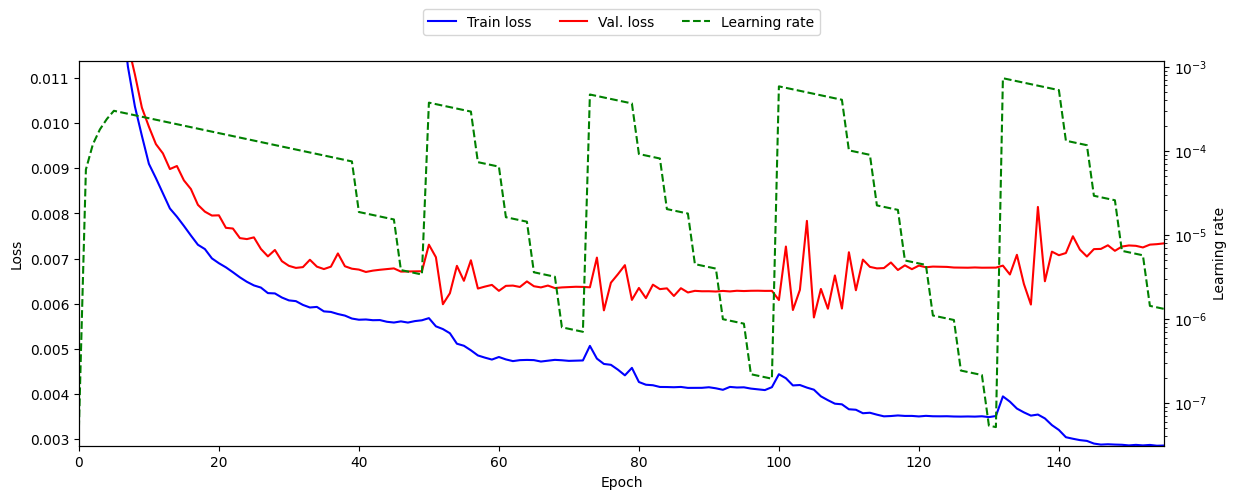

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.70it/s]
The mean absolute error on the test set is: 3.97
The mean absolute error on the shown time series is: 3.07


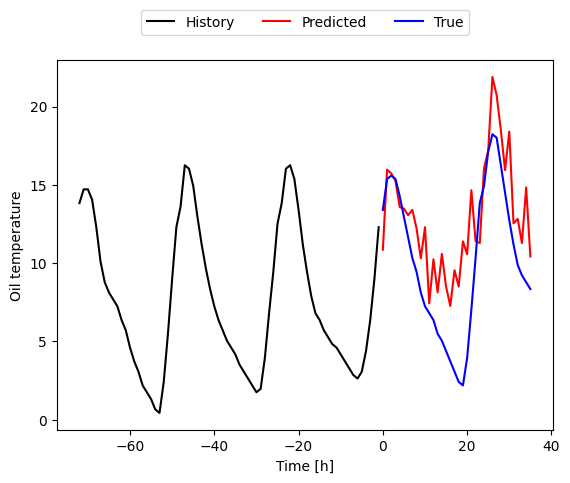

In [18]:
plot_training_progress(trainer3.logger.log_dir + "/metrics.csv")

checkpoint_file = trainer3.checkpoint_callback.best_model_path
model003 = model003.load_from_checkpoint(
    checkpoint_file, pred_len=pred_len, context_len=context_len, 
    n_feat_in=n_feat_in, n_feat_out=n_feat_out, hidden_size=hidden_size, 
    num_levels=num_levels, kernel_size=kernel_size, dropout=dropout, 
    y_cols_idx=y_cols_idx)
model003.eval()

trainer3a = pl.Trainer()
y_test_out3 = trainer3a.predict(model=model003, dataloaders=loader_test_scaled)
y_test_pred3 = torch.cat([x[0] for x in y_test_out3])
y_test3 = torch.cat([x[1] for x in y_test_out3])

y_test_rescaled3 = scaler_y.inverse_transform(y_test3)
y_test_pred_rescaled3 = scaler_y.inverse_transform(y_test_pred3)
mae3 = mean_absolute_error(
    y_test_rescaled3[:, :, 0], y_test_pred_rescaled3[:, :, 0])
print(f"The mean absolute error on the test set is: {mae3:.2f}")

plot_example_time_series(
    y_test_rescaled3, y_test_pred_rescaled3, y_test_history, 23, context_len)

# SCINet with RevIN

Lastly, we will also train the SCINet model with the RevIN module:

In [19]:
lr_after_warmup = 1e-4

cb_a4 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b4 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c4 = LearningRateMonitor(logging_interval="epoch")
logger4 = CSVLogger(
    save_dir="logs_002/", name="model004", flush_logs_every_n_steps=1)


class TrainingModule4(TrainingModuleBase):
    def __init__(self, pred_len, context_len, n_feat_in, n_feat_out, 
                 hidden_size, num_levels, kernel_size, dropout, y_cols_idx):
        super().__init__()
        self.automatic_optimization = False
        self.scinet = SCINet(
            pred_len, context_len, n_feat_in, n_feat_out, hidden_size, 
            num_levels, kernel_size, dropout)
        self.revin = RevIN(n_feat_in, y_cols_idx)
 
    def forward(self, x):
        x = self.revin(x, "norm")
        x = self.scinet(x)
        x = self.revin(x, "denorm")
        return x


model004 = TrainingModule4(
    pred_len=pred_len, context_len=context_len, n_feat_in=n_feat_in, 
    n_feat_out=n_feat_out, hidden_size=hidden_size, num_levels=num_levels, 
    kernel_size=kernel_size, dropout=dropout, y_cols_idx=y_cols_idx)
    

print(summary(model004.to(device), (1, context_len, n_feat_in), depth=5))

trainer4 = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, enable_progress_bar=False,
    callbacks=[cb_a4, cb_b4, cb_c4], logger=logger4, accelerator="cpu")

trainer4.fit(
    model=model004, train_dataloaders=loader_train, val_dataloaders=loader_val)

Layer (type:depth-idx)                                                      Output Shape              Param #
TrainingModule4                                                             [1, 36, 1]                --
├─RevIN: 1-1                                                                [1, 72, 11]               22
├─SCINet: 1-2                                                               [1, 36, 1]                --
│    └─EncoderTree: 2-1                                                     [1, 72, 11]               --
│    │    └─SCINet_Tree: 3-1                                                [1, 72, 11]               --
│    │    │    └─LevelSCINet: 4-1                                           [1, 36, 11]               --
│    │    │    │    └─InteractorLevel: 5-1                                  [1, 11, 36]               39,116
│    │    │    └─SCINet_Tree: 4-2                                           [1, 36, 11]               --
│    │    │    │    └─LevelSCINet: 5-2        

With the RevIN module, we can see an improvement and overall the best results in this notebook:

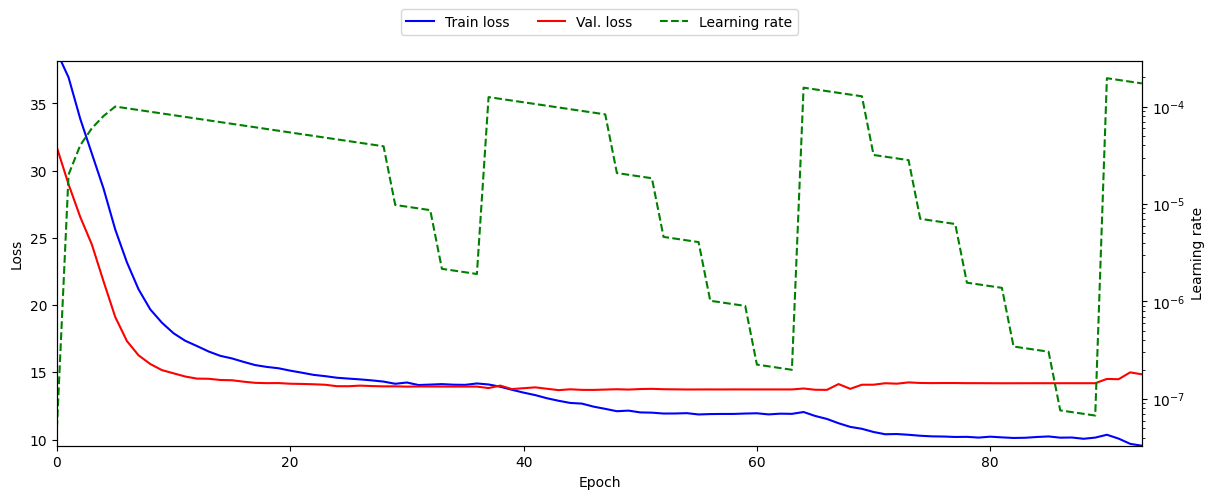

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.04it/s]
The mean absolute error on the test set is: 3.56
The mean absolute error on the shown time series is: 1.95


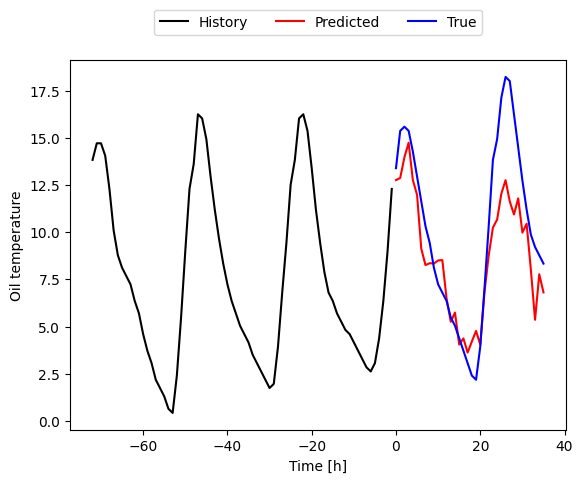

In [20]:
plot_training_progress(trainer4.logger.log_dir + "/metrics.csv")

checkpoint_file = trainer4.checkpoint_callback.best_model_path
model004 = model004.load_from_checkpoint(
    checkpoint_file, pred_len=pred_len, context_len=context_len, 
    n_feat_in=n_feat_in, n_feat_out=n_feat_out, hidden_size=hidden_size, 
    num_levels=num_levels, kernel_size=kernel_size, dropout=dropout, 
    y_cols_idx=y_cols_idx)
model004.eval()

trainer4a = pl.Trainer()
y_test_out4 = trainer4a.predict(model=model004, dataloaders=loader_test)
y_test_pred4 = torch.cat([x[0] for x in y_test_out4])
y_test4 = torch.cat([x[1] for x in y_test_out4])


mae4 = mean_absolute_error(
    y_test4[:, :, 0], y_test_pred4[:, :, 0])
print(f"The mean absolute error on the test set is: {mae4:.2f}")

plot_example_time_series(
    y_test4, y_test_pred4, y_test_history, 23, context_len)

To summarize:

In [21]:
print("Mean absolute errors on test data:")
print(f"Seq2Seq LSTM without RevIN: {mae1:.2f}")
print(f"Seq2Seq LSTM with RevIN: {mae2:.2f}")
print(f"SCINet without RevIN: {mae3:.2f}")
print(f"SCINet with RevIN: {mae4:.2f}")

Mean absolute errors on test data:
Seq2Seq LSTM without RevIN: 3.99
Seq2Seq LSTM with RevIN: 3.79
SCINet without RevIN: 3.97
SCINet with RevIN: 3.56
